# Clsificacación y EDA Clusters Obesity para etiquetado

La variable objetivo no existe dentro del conjunto de datos. Tampoco existe una fórmula que me permita calcularla.

Una solución es utilizar un algoritmo de clasificación no supervisada para identificar los grupos de datos similares y así poder etiquetarlos más fácilmente.

Consideré el algoritmo **KModes** que se basa en encontrar grupos o clusters en un conjunto de datos utilizando la distancia entre las observaciones y los modos de las categorías.

Utilicé este algoritmo con las variables categóricas siguientes: age_range, obesity_bmi, obesity_cc, obesity_rcc, obesity_ict y risk_factors

Como lo que busco es ayudarme a etiquetar los datos, escogí el algoritmo de clasificación que me generara menor cantidad de clusters y datos más homogéneos dentro de cada grupo.

Por esta razón, escogí **KModes** para definir las etiquetas (con KMeans obtuve resultados menos óptimos).

Estudiaré cluster por cluster para definir las etiquetas de cada uno.

#### Tareas:

1. Buscar el número óptimo de clusters utilizando KModes
2. Una vez determinado el número óptimo de clusters, explorar las características de las personas pertenecientes a cada grupo
3. Etiquetar los registros del dataframe basándome en los clusters creados por el algoritmo 
4. Estudio de los datos despues de etiquetados
5. Guardar el DF en un archivo parquet para el resto del estudio
6. Crear un workflow que permita automatizar todo el proceso: 

- Lectura de los datos
- Clasificación y generación de los clusters
- Etiquetado de los datos
- Salvagurada de los datos etiquetados


In [1]:
# Librerías

from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import altair as alt # importar altair con el alias alt

# Transformar columnas
from sklearn.preprocessing import OneHotEncoder, Binarizer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# Clasificación no supervisada
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes

# Métricas para evaluar modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics

# Armando pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

# Funciones propias
import data_common_functions as dcf
import char_common_functions as ccf

In [2]:
def generate_df_kmodes(df):
    
    df_to_transform = df.loc[:, ['age_range', 
                            'obesity_bmi',
                            'obesity_cc',
                            'obesity_rcc',
                            'obesity_ict',
                            'risk_factors'
                                ] ]
    
    columns_to_encode = ['age_range']
    columns_to_scale = []
    # Passthrough columns
    columns_to_pass = [ 'obesity_bmi',
                        'obesity_cc',
                        'obesity_rcc',
                        'obesity_ict',
                        'risk_factors'
                      ]
    
    df_kmodes = dcf.transform_df(df_to_transform, columns_to_encode, columns_to_scale, columns_to_pass)
    
    return df_kmodes

In [3]:
def test_kmodes(df, n_clusters_list):
   
    trained_models = []
    results = []
    
    df_kmodes = generate_df_kmodes(df)
    
    print('*****************************')
    print('TEST KModes')
    print('*****************************')
    
    for n_clusters in n_clusters_list:

        model = KModes(n_clusters=n_clusters, init='Huang', n_init=10, random_state=42)
        model.fit(df_kmodes)
        print("n_clusters", n_clusters, model.cost_)
        trained_models.append(model)

        # Métricas del modelo
        result = {
            'model': 'KModes',
            'n_clusters': n_clusters,
            'cost': model.cost_,
            'silhouette_score': silhouette_score(df_kmodes, model.labels_),
            'calinski_harabasz_score': calinski_harabasz_score(df_kmodes, model.labels_),
            'davies_bouldin_score': davies_bouldin_score(df_kmodes, model.labels_)
        }
            
        results.append(result)
        
    costs = [model.cost_ for model in trained_models]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(n_clusters_list, costs , marker='o')
    ax.set_xlabel('Número de clusters')
    ax.set_ylabel('Costo')
    ax.set_title(f'Regla del codo KModes')
      
    return pd.DataFrame(results)
 

In [4]:
def char_cluster(df):
    
    title = 'Cantidad de individuos por etiqueta'
    
    tooltip=[alt.Tooltip('label:N'),
             alt.Tooltip('count(*):Q', title='Cantidad individuos')]
    
    bars = alt.Chart(df).mark_bar().encode(
        x='count(*):Q',
        y='label:N',
        tooltip=tooltip,
        color=alt.Color('label:N') 
    ).properties(
        title=title,
        width=500, 
        height=250
    )

    return bars

def char_cluster_risk_factors(df, cluster):
    
    query = f'cluster=={cluster}'
    
    df = df.query(query)[['cluster', 'risk_factors']]
    
    sns.countplot(x='cluster', hue='risk_factors', data=df)
    return plt.show()


def char_cluster_age(df, cluster):
    
    query = f'cluster=={cluster}'
    
    df = df.query(query)[['cluster', 'age_range']]
    
    sns.countplot(x='cluster', hue='age_range', data=df)
    return plt.show()

def char_cluster_genre(df, cluster):
    
    query = f'cluster=={cluster}'
    
    df = df.query(query)[['cluster', 'gender']]
    
    sns.countplot(x='cluster', hue='gender', data=df)
    return plt.show()


def define_label(bmi, cc, rcc, ict):
    return bmi + '-' + cc + '-' + rcc + '-' + ict

def eda_cluster(df, cluster):   
    
    print(f'EDA cluster {cluster}')
    print('**************************')
    
    query = f'cluster=={cluster}'
    df_table = df.query(query)[[#'gender', 
                                'age_range',
                                'obesity_bmi_txt', 'obesity_cc_txt',  
                                'obesity_rcc_txt', 'obesity_ict_txt', 
                                'risk_factors', 'cluster']]
    df_eda_cluster = pd.pivot_table(df_table, 
                                index=[#'gender', 
                                       'age_range',
                                       'obesity_bmi_txt', 'obesity_cc_txt',  
                                       'obesity_rcc_txt', 'obesity_ict_txt', 'risk_factors'],
                                    aggfunc='count')
    
    print(df_eda_cluster)   
    
    df_eda_cluster.reset_index(inplace=True)
    
    df_eda_cluster.rename(columns={'obesity_bmi_txt': 'bmi',
                                  'obesity_cc_txt': 'cc',
                                  'obesity_rcc_txt': 'rcc',
                                  'obesity_ict_txt': 'ict'
                                 }, inplace=True)

    df_eda_cluster['label'] = df_eda_cluster.apply(lambda  row: define_label(row['bmi'], row['cc'],
                                                                      row['rcc'], row['ict']), axis=1)
    
    char_cluster_risk_factors(df, cluster)
    char_cluster_genre(df, cluster)
    char_cluster_age(df, cluster)
    
    #return char_cluster(df_eda_cluster)

In [5]:
def generate_kmodes_clusters(df, n_clusters, n_init, random_state, eda_report=True):    
    
    df_kmodes = generate_df_kmodes(df)
    
    k_modes = KModes(n_clusters=n_clusters, init='Huang', n_init=n_init, random_state=random_state)
    cluster_labels = k_modes.fit_predict(df_kmodes)

    # Agrega los resultados de la agrupación al dataframe original
    df['cluster'] = cluster_labels

    # Evalúa el rendimiento del clustering utilizando el coeficiente de silueta
    silhouette_avg = silhouette_score(df_kmodes, cluster_labels)
    print("Coeficiente de Silueta:", silhouette_avg)

    # Muestra la distribución de los datos en cada cluster
    cluster_counts = df['cluster'].value_counts()
    print("Distribución de datos en cada cluster:\n", cluster_counts)

    # Generamos el reporte solo durante el estudio
    if eda_report:
        # EDA de cada cluster para identificar patrones
        for i in range(n_clusters):
            eda_cluster(df, i)
    

## Clasificación y EDA de los clusters. Generación de la variable Obesity

In [6]:
# Leemos el archivo
CURRENT_DIR = Path.cwd()

BASE_DIR = Path(CURRENT_DIR).parent

df_obesity = dcf.read_file(f"{BASE_DIR}/data/out/obesity.parquet")

df_obesity

,age,age_range,gender,height,weight,waist_circum_preferred,hip_circum,gender_bin,bmi,rcc,ict,obesity_bmi,obesity_bmi_txt,obesity_cc,obesity_cc_txt,obesity_rcc,obesity_rcc_txt,obesity_ict,obesity_ict_txt,risk_factors
1,47.0,46-55,male,187.1980,156.630,138.5062,142.1892,1,44.696399,0.974098,0.739891,3,3-Obesidad,1,1-Alto,1,1-Medio,3,3-Obesidad,4
2,50.0,46-55,male,180.5940,98.064,98.3996,109.9058,1,30.067891,0.895309,0.544866,3,3-Obesidad,1,1-Alto,0,0-Bajo,2,2-Sobrepeso,3
3,28.0,26-35,male,182.7022,89.211,97.0026,107.0102,1,26.725809,0.906480,0.530933,2,2-Sobrepeso,1,1-Alto,0,0-Bajo,2,2-Sobrepeso,3
4,52.0,46-55,male,185.9026,113.273,105.9942,111.0996,1,32.775964,0.954047,0.570160,3,3-Obesidad,1,1-Alto,1,1-Medio,2,2-Sobrepeso,4
5,50.0,46-55,male,183.1086,108.279,104.0892,112.3950,1,32.294365,0.926102,0.568456,3,3-Obesidad,1,1-Alto,0,0-Bajo,2,2-Sobrepeso,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,35.0,26-35,female,152.8064,49.259,61.5950,93.0910,0,21.096116,0.661664,0.403092,1,1-Normal,0,0-Bajo,0,0-Bajo,0,0-Delgado,0
4461,40.0,36-45,female,168.6052,67.646,73.8124,100.4062,0,23.795794,0.735138,0.437782,1,1-Normal,0,0-Bajo,0,0-Bajo,1,1-Normal,0
4462,23.0,17-25,female,168.5036,73.775,78.0034,109.7026,0,25.983093,0.711044,0.462918,2,2-Sobrepeso,0,0-Bajo,0,0-Bajo,1,1-Normal,1
4463,24.0,17-25,male,170.5102,65.149,75.7936,97.7900,1,22.408203,0.775065,0.444511,1,1-Normal,0,0-Bajo,0,0-Bajo,1,1-Normal,0


## Clasificación no supervisada

#### Probar KMode: 2 a 10 clusters

1. Con los datos categóricos: Indicadores de obesidad

Para encontrar el número óptimo de clusters utilizare:

- **KModes:** Costos,coheficiente de Silhouette, Índice Calinski Harabasz, Índice Ddavies Bouldin
- Regla del codo


### Test KModes

Para saber la cantidad óptima de clusters

*****************************
TEST KModes
*****************************
n_clusters 2 8370.0
n_clusters 3 7152.0
n_clusters 4 6464.0
n_clusters 5 5460.0
n_clusters 6 5078.0
n_clusters 8 4368.0
n_clusters 10 3962.0


,model,n_clusters,cost,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,KModes,2,8370.0,0.475609,4940.971737,0.879780
1,KModes,3,7152.0,0.296425,3019.747223,1.442971
2,KModes,4,6464.0,0.184387,2028.519038,4.131940
3,KModes,5,5460.0,0.113688,1759.490118,2.851721
4,KModes,6,5078.0,0.225071,1637.844286,1.999665
5,KModes,8,4368.0,0.120701,1265.153447,2.692906
6,KModes,10,3962.0,0.307597,1529.609753,1.774809


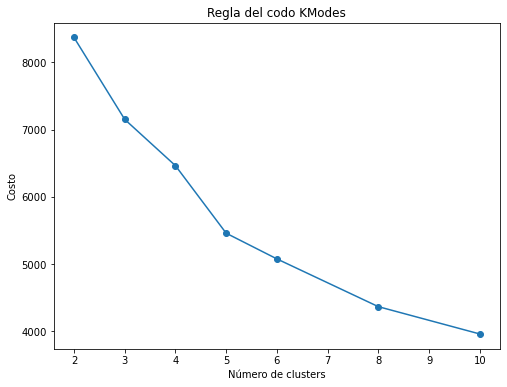

In [7]:
n_clusters_list = [2, 3, 4, 5, 6, 8, 10]

result = test_kmodes(df_obesity, n_clusters_list)

result

### Conclusión:

Según los indicadores y siguiendo la regla del codo mostrada en el gráfico, 6 clusters parece ser un número óptimo para clasificar los datos.

A continuación estudiaré cada uno de los clusters para determinar los valores de las variables que caracterizan cada grupo y poder definir cómo etiquetarlos.

Para hacer el etiquetado, me baso en las investigaciones hechas sobre la obesidad y los factores de riesgo.

En un problema real, esta tarea de etiquetado debería ser realizado por personal especializado en el tema.

El buen etiquetado de los datos es la clave para obtener un modelo para hacer predicciones, que sea de calidad.

### Estudio clusters KModes

Coeficiente de Silueta: 0.22507070832157286
Distribución de datos en cada cluster:
 0    2206
5     585
2     541
1     434
3     353
4     311
Name: cluster, dtype: int64
EDA cluster 0
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         0-Bajo          0-Delgado       0                  23
                                                         1-Normal        0                  17
                                         1-Medio         0-Delgado       1                   1
                                                         1-Normal        1                   5
                                         2-Alto          1-Normal        1                   1
          1-Normal        0-Bajo         0-Bajo          0-Delgado       0                  74
                           

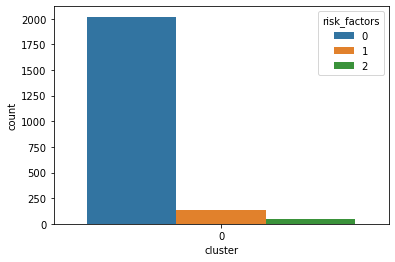

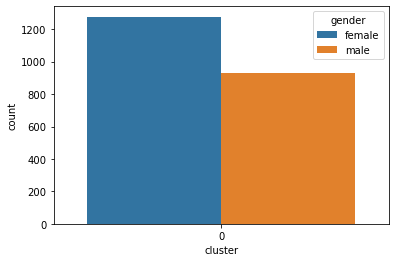

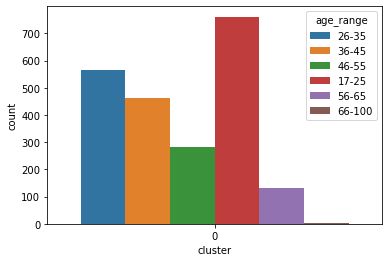

EDA cluster 1
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     1-Normal        1-Alto         1-Medio         2-Sobrepeso     3                  24
          2-Sobrepeso     1-Alto         1-Medio         2-Sobrepeso     4                  12
                                                         3-Obesidad      4                   2
                                         2-Alto          2-Sobrepeso     4                   4
          3-Obesidad      1-Alto         1-Medio         2-Sobrepeso     4                   2
26-35     1-Normal        1-Alto         1-Medio         2-Sobrepeso     3                  12
          2-Sobrepeso     1-Alto         1-Medio         2-Sobrepeso     4                  23
                                         2-Alto          2-Sobrepeso     4                   6
         

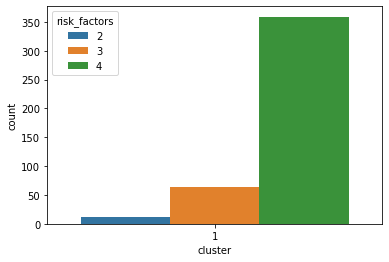

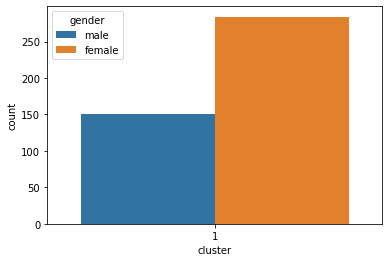

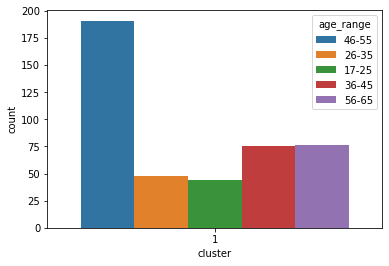

EDA cluster 2
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     2-Sobrepeso     0-Bajo         0-Bajo          0-Delgado       1                   1
                                                         1-Normal        1                  78
26-35     0-Bajo Peso     0-Bajo         1-Medio         1-Normal        1                   2
                                         2-Alto          1-Normal        1                   1
                          1-Alto         2-Alto          1-Normal        2                   1
          1-Normal        0-Bajo         0-Bajo          2-Sobrepeso     1                   7
                                         1-Medio         1-Normal        1                  10
                          1-Alto         0-Bajo          1-Normal        1                  19
         

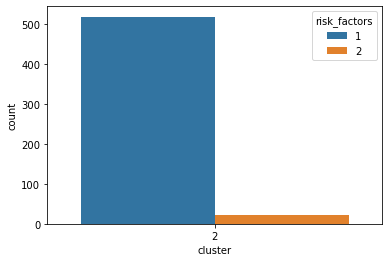

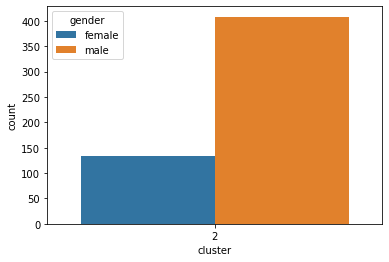

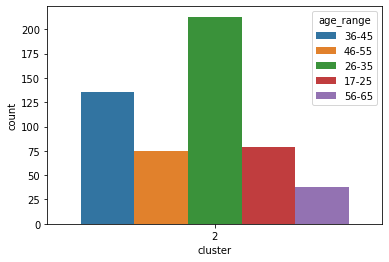

EDA cluster 3
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     1-Normal        1-Alto         2-Alto          3-Obesidad      3                   1
          2-Sobrepeso     1-Alto         2-Alto          3-Obesidad      4                   2
          3-Obesidad      1-Alto         0-Bajo          3-Obesidad      3                   9
                                         1-Medio         3-Obesidad      4                   6
                                         2-Alto          3-Obesidad      4                   5
26-35     3-Obesidad      1-Alto         0-Bajo          3-Obesidad      3                  13
                                         1-Medio         3-Obesidad      4                  19
                                         2-Alto          3-Obesidad      4                  25
36-45    

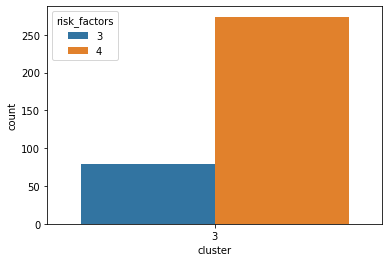

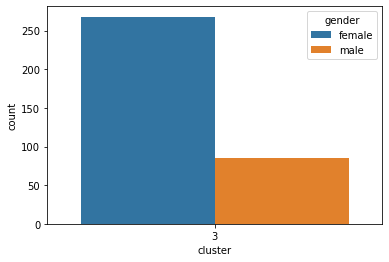

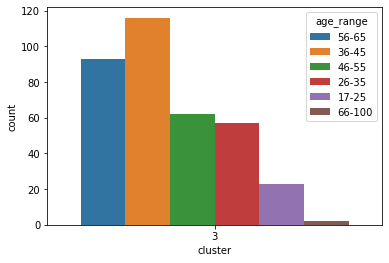

EDA cluster 4
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         2-Alto          2-Sobrepeso     2                   1
          2-Sobrepeso     0-Bajo         0-Bajo          2-Sobrepeso     2                  19
          3-Obesidad      0-Bajo         0-Bajo          2-Sobrepeso     2                   4
26-35     1-Normal        0-Bajo         1-Medio         2-Sobrepeso     2                   7
                                         2-Alto          2-Sobrepeso     2                   1
                          1-Alto         0-Bajo          2-Sobrepeso     2                   7
          2-Sobrepeso     0-Bajo         0-Bajo          2-Sobrepeso     2                  37
          3-Obesidad      0-Bajo         0-Bajo          2-Sobrepeso     2                   8
36-45    

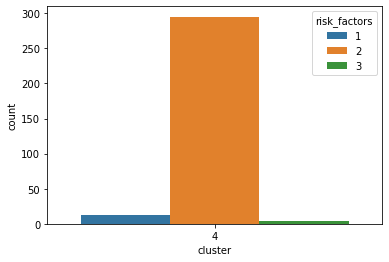

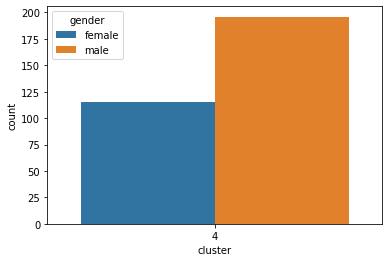

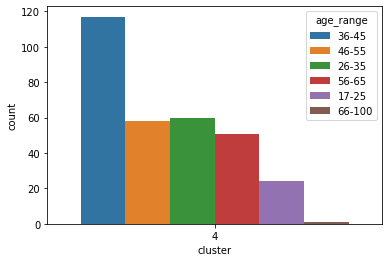

EDA cluster 5
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     1-Normal        1-Alto         2-Alto          2-Sobrepeso     3                  13
          2-Sobrepeso     1-Alto         0-Bajo          2-Sobrepeso     3                  36
          3-Obesidad      1-Alto         0-Bajo          2-Sobrepeso     3                  21
26-35     1-Normal        1-Alto         2-Alto          2-Sobrepeso     3                   6
          2-Sobrepeso     1-Alto         0-Bajo          2-Sobrepeso     3                  54
          3-Obesidad      1-Alto         0-Bajo          2-Sobrepeso     3                  65
36-45     2-Sobrepeso     1-Alto         0-Bajo          2-Sobrepeso     3                  68
          3-Obesidad      1-Alto         0-Bajo          2-Sobrepeso     3                  63
46-55    

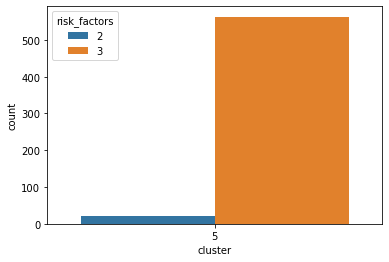

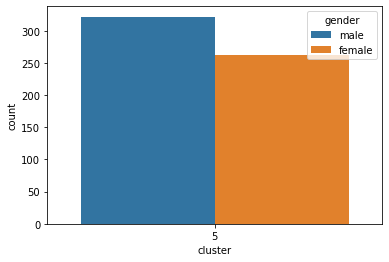

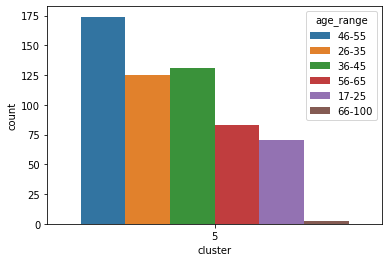

In [32]:
n_clusters = 6
n_init = 10
random_state = 42

generate_kmodes_clusters(df_obesity, n_clusters, n_init, random_state)

### Conclusiones

En vista de que el algoritmo sólo lo voy a usar para ayudarme a etiquetar los registros, busco simplemente cuál en la mejor clasificación: menor número de clusters, grupos más homogéneos.

En este caso, escogeré **KModes** para definir las etiquetas.

Estudiaré cluster por cluster para definir las etiquetas de cada uno.

### Etiquetado basado en KModes

### Cluster 0

Individuos mayoritariamente con 0 o 1 factor de riesgo, que generalmente significa personas sanas, con un riesgo bajo o nulo de padecer obesidad y ENT.

La edad y la cantidad de factores de riesgo, pueden se motivo para clasificar a una persona con un riego moderado (1) o alto (2). 

Ser mayor de 35 años y/o acumular grasa abdominal (cc==1 or rcc==2) pueden significar algún tipo de riesgo.

In [44]:
def calc_obesity_kmodes_0(age, bmi, cc, rcc, ict, risk):
    
    if risk==0: return 0
    
    # Si 1 riesgo y es acumulación de grasa abdominal, riesgo 1. Sino riesgo 0
    if risk==1: 
        if age>=35 and (cc==1 or rcc==2): return 1
        else: return 0
       
    if risk==2:        
        if age>=35 and (cc==1 and rcc==2): return 2  
        else: return 1
        


EDA cluster 0
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         0-Bajo          0-Delgado       0                  23
                                                         1-Normal        0                  17
                                         1-Medio         0-Delgado       1                   1
                                                         1-Normal        1                   5
                                         2-Alto          1-Normal        1                   1
          1-Normal        0-Bajo         0-Bajo          0-Delgado       0                  74
                                                         1-Normal        0                 541
                                                         2-Sobrepeso     1                  13
         

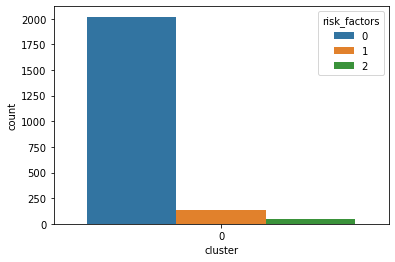

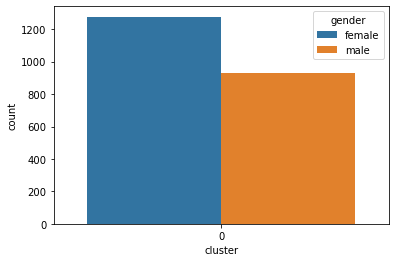

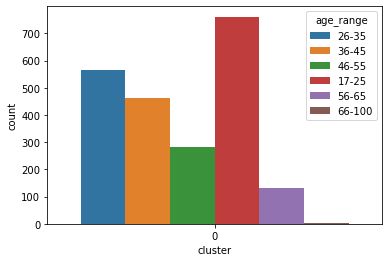

In [45]:
eda_cluster(df_obesity, 0)

### Cluster 1

La mayoría tiene al menos 3 factores de riesgo

In [58]:
def calc_obesity_kmodes_1(age, bmi, cc, rcc, ict, risk):
          
    if risk>=3: return 2
       
    if risk==2:        
        if age>=35 and (cc==1 or rcc==2): return 2  
        else: return 1
        
   

EDA cluster 1
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     1-Normal        1-Alto         1-Medio         2-Sobrepeso     3                  24
          2-Sobrepeso     1-Alto         1-Medio         2-Sobrepeso     4                  12
                                                         3-Obesidad      4                   2
                                         2-Alto          2-Sobrepeso     4                   4
          3-Obesidad      1-Alto         1-Medio         2-Sobrepeso     4                   2
26-35     1-Normal        1-Alto         1-Medio         2-Sobrepeso     3                  12
          2-Sobrepeso     1-Alto         1-Medio         2-Sobrepeso     4                  23
                                         2-Alto          2-Sobrepeso     4                   6
         

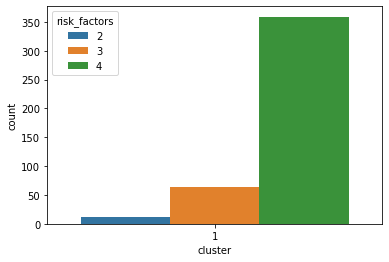

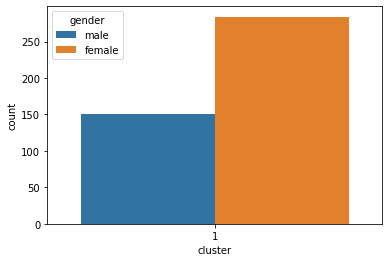

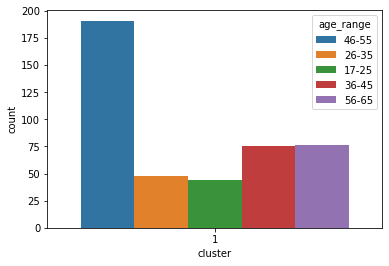

In [59]:
eda_cluster(df_obesity, 1)

### Cluster 2

Considero que toda persona con 3 o más factores de riesgo, tiene un riesgo alto de padecer obesidad y/o ENT.

En el caso de personas con 2 factores de riesgo, tomaré en cuenta la edad y la acumulación de grasa abdominal:

Ser mayor de 35 años y acumular grasa abdominal (cc==1 or rcc==2) significa tener un riesgo alto (2). Si se es más jóven pero igual la grasa abdominal es importante, hay riesgo moderado (1).

In [60]:
def calc_obesity_kmodes_2(age, bmi, cc, rcc, ict, risk):      
        
    if risk==1: 
        if age>=35: return 1
        elif age<=35 and bmi>=2: return 1
        else: return 0
       
    if risk==2: return 2

EDA cluster 2
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     2-Sobrepeso     0-Bajo         0-Bajo          0-Delgado       1                   1
                                                         1-Normal        1                  78
26-35     0-Bajo Peso     0-Bajo         1-Medio         1-Normal        1                   2
                                         2-Alto          1-Normal        1                   1
                          1-Alto         2-Alto          1-Normal        2                   1
          1-Normal        0-Bajo         0-Bajo          2-Sobrepeso     1                   7
                                         1-Medio         1-Normal        1                  10
                          1-Alto         0-Bajo          1-Normal        1                  19
         

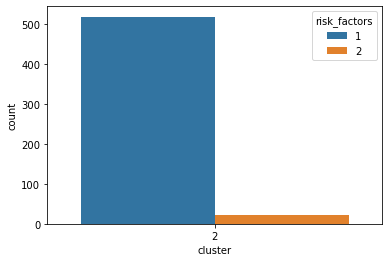

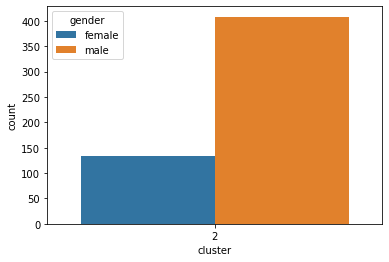

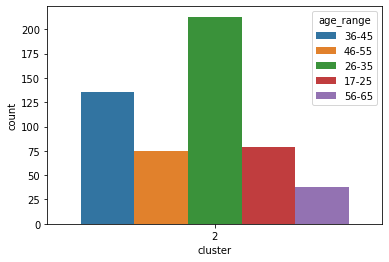

In [61]:
eda_cluster(df_obesity, 2)

### Cluster 3

Todos tienen al menos 3 factores de riesgo.

Es un grupo básicamente de personas con alto riesgo de padecer obesidad y ENT.

In [62]:
def calc_obesity_kmodes_3(age, bmi, cc, rcc, ict, risk):
      
    if risk>=3: return 2

        
        

EDA cluster 3
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     1-Normal        1-Alto         2-Alto          3-Obesidad      3                   1
          2-Sobrepeso     1-Alto         2-Alto          3-Obesidad      4                   2
          3-Obesidad      1-Alto         0-Bajo          3-Obesidad      3                   9
                                         1-Medio         3-Obesidad      4                   6
                                         2-Alto          3-Obesidad      4                   5
26-35     3-Obesidad      1-Alto         0-Bajo          3-Obesidad      3                  13
                                         1-Medio         3-Obesidad      4                  19
                                         2-Alto          3-Obesidad      4                  25
36-45    

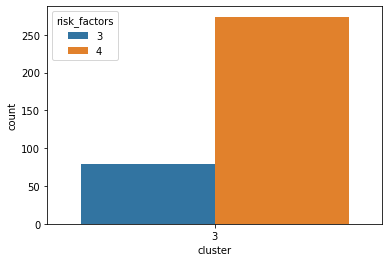

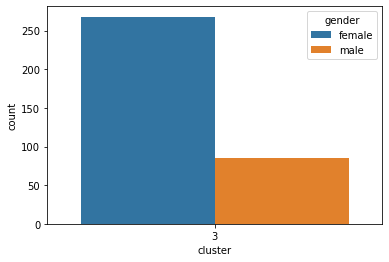

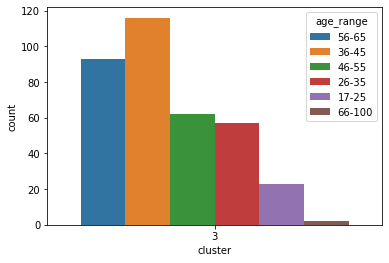

In [63]:
eda_cluster(df_obesity, 3)

### Cluster 4

Todos los individuos tienen al menos 3.

Es un grupo de personas con alto riesgo de padecer obesidad y ENT.

In [64]:
def calc_obesity_kmodes_4(age, bmi, cc, rcc, ict, risk):
    
    if risk>=3: return 2
    
    if risk==1: return 0    
       
    if risk==2:        
        if age>=35 and (cc==1 or rcc==2 or bmi==3): return 2  
        elif: age<=35 and bmi==3: return 2
        else: return 1

SyntaxError: invalid syntax (3521671350.py, line 9)

EDA cluster 4
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     0-Bajo Peso     0-Bajo         2-Alto          2-Sobrepeso     2                   1
          2-Sobrepeso     0-Bajo         0-Bajo          2-Sobrepeso     2                  19
          3-Obesidad      0-Bajo         0-Bajo          2-Sobrepeso     2                   4
26-35     1-Normal        0-Bajo         1-Medio         2-Sobrepeso     2                   7
                                         2-Alto          2-Sobrepeso     2                   1
                          1-Alto         0-Bajo          2-Sobrepeso     2                   7
          2-Sobrepeso     0-Bajo         0-Bajo          2-Sobrepeso     2                  37
          3-Obesidad      0-Bajo         0-Bajo          2-Sobrepeso     2                   8
36-45    

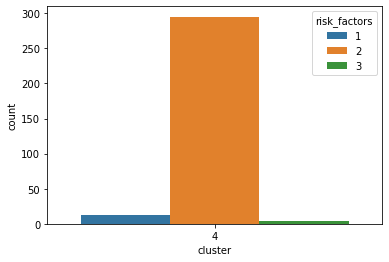

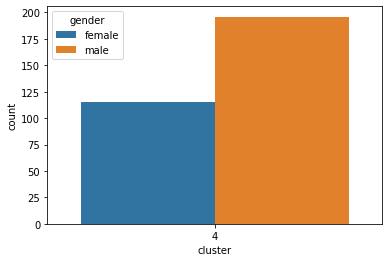

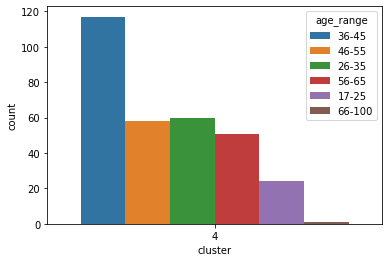

In [65]:
eda_cluster(df_obesity, 4)

### Cluster 5

La mayoría de los individuos tienen al menos 3 riesgos. 

Los que tienen 2 riesgos, son mayores de 35 años y tienen acumulación de grasa abdominal.

Es un grupo de personas con alto riesgo de padecer obesidad y ENT.

In [66]:
def calc_obesity_kmodes_5(age, bmi, cc, rcc, ict, risk):
    
    return 2
        
        

EDA cluster 5
**************************
                                                                                       cluster
age_range obesity_bmi_txt obesity_cc_txt obesity_rcc_txt obesity_ict_txt risk_factors         
17-25     1-Normal        1-Alto         2-Alto          2-Sobrepeso     3                  13
          2-Sobrepeso     1-Alto         0-Bajo          2-Sobrepeso     3                  36
          3-Obesidad      1-Alto         0-Bajo          2-Sobrepeso     3                  21
26-35     1-Normal        1-Alto         2-Alto          2-Sobrepeso     3                   6
          2-Sobrepeso     1-Alto         0-Bajo          2-Sobrepeso     3                  54
          3-Obesidad      1-Alto         0-Bajo          2-Sobrepeso     3                  65
36-45     2-Sobrepeso     1-Alto         0-Bajo          2-Sobrepeso     3                  68
          3-Obesidad      1-Alto         0-Bajo          2-Sobrepeso     3                  63
46-55    

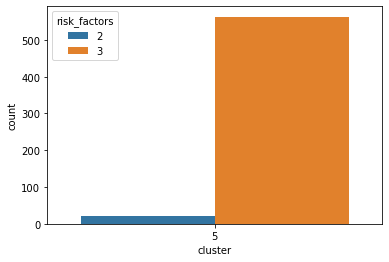

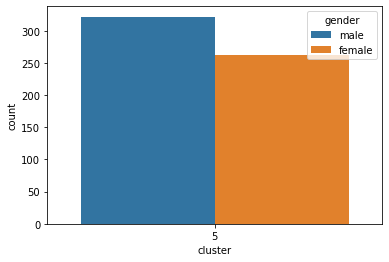

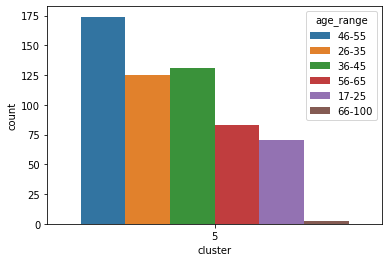

In [67]:
eda_cluster(df_obesity, 5)

## Cálculo de la variable objetivo

Calculamos el riesgo de sufrir sobrepeso/obesidad y de padecer ENT. 3 Valores:

- **0:** Riesgo nulo o bajo
- **1:** Riesgo moderado
- **2:** Riesgo alto

In [68]:
def calc_obesity(age, bmi, cc, rcc, ict, risk, cluster):
    if cluster==0: return calc_obesity_kmodes_0(age, bmi, cc, rcc, ict, risk)
    if cluster==1: return calc_obesity_kmodes_1(age, bmi, cc, rcc, ict, risk)
    if cluster==2: return calc_obesity_kmodes_2(age, bmi, cc, rcc, ict, risk)
    if cluster==3: return calc_obesity_kmodes_3(age, bmi, cc, rcc, ict, risk)
    if cluster==4: return calc_obesity_kmodes_4(age, bmi, cc, rcc, ict, risk)
    if cluster==5: return calc_obesity_kmodes_4(age, bmi, cc, rcc, ict, risk)

    

In [69]:
df_obesity['obesity'] = df_obesity.apply(lambda  row: calc_obesity(row['age'],
                                                                   row['obesity_bmi'],
                                                                   row['obesity_cc'], 
                                                                   row['obesity_rcc'],
                                                                   row['obesity_ict'],
                                                                   row['risk_factors'],
                                                                   row['cluster']), 
                                            axis=1)
                                         
                                         
df_obesity

,age,age_range,gender,height,weight,waist_circum_preferred,hip_circum,gender_bin,bmi,rcc,...,obesity_bmi_txt,obesity_cc,obesity_cc_txt,obesity_rcc,obesity_rcc_txt,obesity_ict,obesity_ict_txt,risk_factors,cluster,obesity
1,47.0,46-55,male,187.1980,156.630,138.5062,142.1892,1,44.696399,0.974098,...,3-Obesidad,1,1-Alto,1,1-Medio,3,3-Obesidad,4,1,2
2,50.0,46-55,male,180.5940,98.064,98.3996,109.9058,1,30.067891,0.895309,...,3-Obesidad,1,1-Alto,0,0-Bajo,2,2-Sobrepeso,3,5,2
3,28.0,26-35,male,182.7022,89.211,97.0026,107.0102,1,26.725809,0.906480,...,2-Sobrepeso,1,1-Alto,0,0-Bajo,2,2-Sobrepeso,3,5,2
4,52.0,46-55,male,185.9026,113.273,105.9942,111.0996,1,32.775964,0.954047,...,3-Obesidad,1,1-Alto,1,1-Medio,2,2-Sobrepeso,4,1,2
5,50.0,46-55,male,183.1086,108.279,104.0892,112.3950,1,32.294365,0.926102,...,3-Obesidad,1,1-Alto,0,0-Bajo,2,2-Sobrepeso,3,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,35.0,26-35,female,152.8064,49.259,61.5950,93.0910,0,21.096116,0.661664,...,1-Normal,0,0-Bajo,0,0-Bajo,0,0-Delgado,0,0,0
4461,40.0,36-45,female,168.6052,67.646,73.8124,100.4062,0,23.795794,0.735138,...,1-Normal,0,0-Bajo,0,0-Bajo,1,1-Normal,0,0,0
4462,23.0,17-25,female,168.5036,73.775,78.0034,109.7026,0,25.983093,0.711044,...,2-Sobrepeso,0,0-Bajo,0,0-Bajo,1,1-Normal,1,2,1
4463,24.0,17-25,male,170.5102,65.149,75.7936,97.7900,1,22.408203,0.775065,...,1-Normal,0,0-Bajo,0,0-Bajo,1,1-Normal,0,0,0


In [70]:
df_obesity['obesity'].value_counts()

0    2169
2    1699
1     562
Name: obesity, dtype: int64

In [71]:
# Guardamos el resultado en un archivo parquet para el entrenamiento del modelo
    
df_obesity.to_parquet(f"{BASE_DIR}/data/out/obesity_labeled.parquet", 
                compression='GZIP',
                engine='pyarrow')

### EDA de la Obesidad calculada

In [72]:
# Estudio Obesidad y riesgo de ENT (calculado)

x = 'count(*):Q'
y = 'age_range:O'
detail = 'obesity:N'

title='Cantidad de Individuos según su rango de edad y su grado de riesgo (obesity)'

title_x = 'Total individuos'
title_y = 'Rangos de Edad'

char_total = ccf.char_bars(df_obesity, x, y, detail, title, title_x, title_y)

char_total



alt.LayerChart(...)

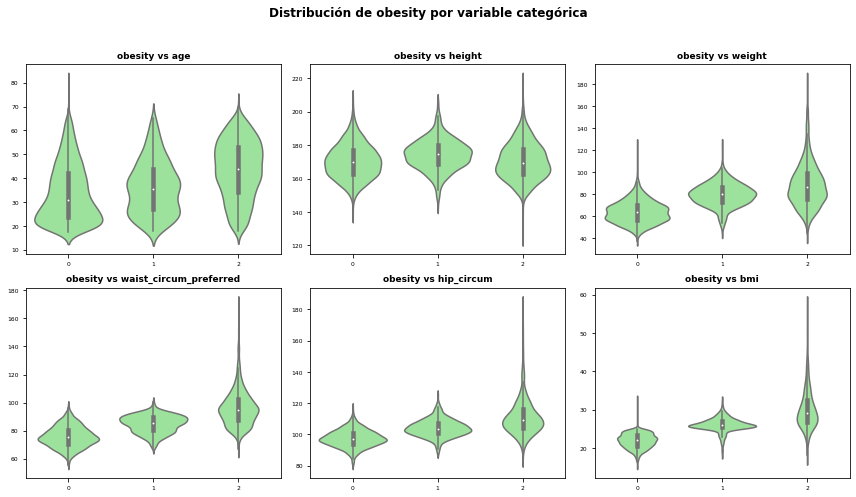

In [73]:
ccf.distribution_var_categ(df_obesity, 'obesity', True)


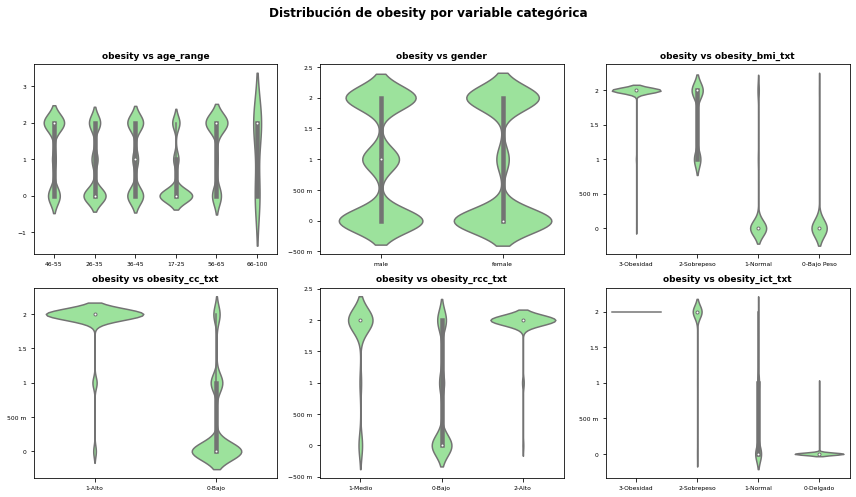

In [74]:
ccf.distribution_var_categ(df_obesity, 'obesity')

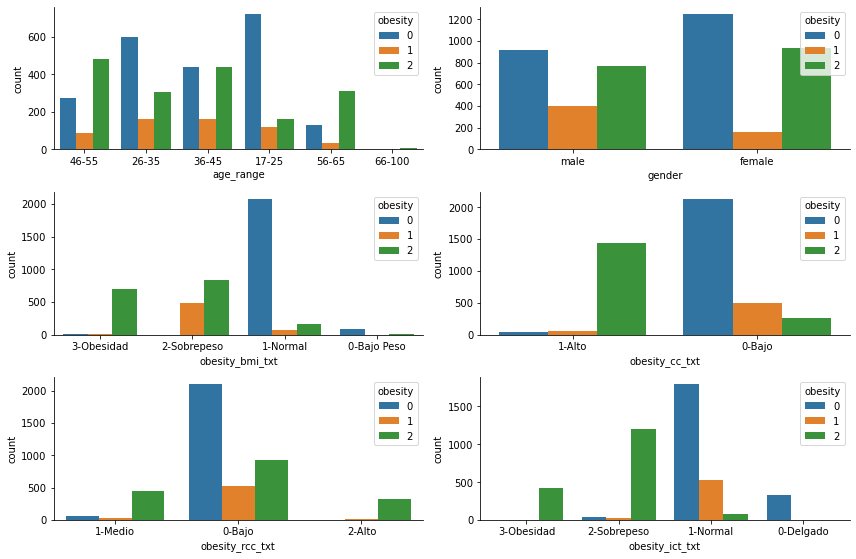

In [75]:
# Configurar el diseño de 3x2
plt.figure(figsize=(12, 10))  # Ajusta el tamaño de la figura según tus necesidades

# Gráfico 1
plt.subplot(4, 2, 1)
sns.despine()
sns.countplot(x='age_range', hue='obesity', data=df_obesity)

# Gráfico 2
plt.subplot(4, 2, 2)
sns.despine()
sns.countplot(x='gender', hue='obesity', data=df_obesity)

# Gráfico 3
plt.subplot(4, 2, 3)
sns.despine()
sns.countplot(x='obesity_bmi_txt', hue='obesity', data=df_obesity)

# Gráfico 4
plt.subplot(4, 2, 4)
sns.despine()
sns.countplot(x='obesity_cc_txt', hue='obesity', data=df_obesity)

# Gráfico 5
plt.subplot(4, 2, 5)
sns.despine()
sns.countplot(x='obesity_rcc_txt', hue='obesity', data=df_obesity)

# Gráfico 6
plt.subplot(4, 2, 6)
sns.despine()
sns.countplot(x='obesity_ict_txt', hue='obesity', data=df_obesity)

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()

## Workflow para etiquetar los datos

**Tareas:**

1. Lectura de los datos
2. Clasificación y generación de los clusters
3. Etiquetado de los datos
4. Salvagurada de los datos etiquetados

In [76]:
def label_data():
    
    # Leo los datos
    CURRENT_DIR = Path.cwd()

    BASE_DIR = Path(CURRENT_DIR).parent

    df_obesity = dcf.read_file(f"{BASE_DIR}/data/out/obesity.parquet")
    
    # Generación de los cluster
    # Importante conservar los parámetros utilizados durante el estudio
    n_clusters = 6
    n_init = 10
    random_state = 42
    
    generate_kmodes_clusters(df_obesity, n_clusters, n_init, random_state, False)
    
    # Asignación de las etiquetas
    
    df_obesity['obesity'] = df_obesity.apply(lambda  row: calc_obesity(row['age'],
                                                                   row['obesity_bmi'],
                                                                   row['obesity_cc'], 
                                                                   row['obesity_rcc'],
                                                                   row['obesity_ict'],
                                                                   row['risk_factors'],
                                                                   row['cluster']), 
                                            axis=1)
    
    print('\nResgistros por etiqueta obesity\n')
    print(df_obesity['obesity'].value_counts())
    
    # Guardamos el resultado en un archivo parquet para el entrenamiento del modelo
    df_obesity.to_parquet(f"{BASE_DIR}/data/out/obesity_labeled.parquet", 
                    compression='GZIP',
                    engine='pyarrow')

In [77]:
label_data()

Coeficiente de Silueta: 0.22507070832157286
Distribución de datos en cada cluster:
 0    2206
5     585
2     541
1     434
3     353
4     311
Name: cluster, dtype: int64

Resgistros por etiqueta obesity

0    2169
2    1699
1     562
Name: obesity, dtype: int64
